<a href="https://colab.research.google.com/github/agustinivandinocco-python/pythonpracticateoria/blob/main/Colab/Clase_08_teoria_2025_portafolio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimizacion Sharpe via Scipy

In [ ]:
import yfinance as yf
import numpy as np
from scipy import optimize


def sharpe_neg(weights):
    FREE_RISK = 0.045
    global ret_log
    weights = np.array(weights)
    ret = np.sum(ret_log.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T,np.dot(ret_log.cov()*252,weights)))
    sr = (ret-FREE_RISK)/vol
    return -sr

def check_sum(weights):
    return np.sum(weights) -1

In [ ]:
df = yf.download(['GGAL','AAPL','NVDA'], start='2023-01-01', end='2024-01-01')['Close']
df = df.loc[~(df==0).any(axis=1)]
ret_log = np.log((df/df.shift(1)).dropna())

cons = ({'type':'eq','fun':check_sum})
bounds = [(0.05,1)] * len(ret_log.columns)
init_guess = [0.1] * len(ret_log.columns)

opt_results = optimize.minimize(sharpe_neg, init_guess, bounds=bounds, constraints=cons)
opt_results

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  3 of 3 completed


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -2.842108539741253
       x: [ 4.567e-01  1.209e-01  4.224e-01]
     nit: 8
     jac: [-1.655e-01 -1.705e-01 -1.655e-01]
    nfev: 34
    njev: 8

In [ ]:
(opt_results['x'] * 100).round(2)

array([45.67, 12.09, 42.24])

In [ ]:
df

Ticker,AAPL,GGAL,NVDA
Date,,,
2023-01-03,123.470612,8.177473,14.303280
2023-01-04,124.744133,8.468609,14.736924
2023-01-05,123.421242,9.042316,14.253321
2023-01-06,127.962433,9.504707,14.846833
2023-01-09,128.485641,9.761590,15.615206
...,...,...,...
2023-12-22,192.192551,16.886625,48.811672
2023-12-26,191.646545,16.534050,49.260498
2023-12-27,191.745819,16.450542,49.398445


# Markowitz por montecarlo

## Repaso básico concepto Sharpe Ratio

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np

FREE_RISK = 0.045
df = yf.download(['GGAL','AAPL','NVDA'], start='2023-01-01', end='2024-01-01')['Close']
df = df.loc[~(df==0).any(axis=1)]
retornos = np.log((df/df.shift(1)).dropna())

[*********************100%***********************]  3 of 3 completed


In [ ]:
datosTickers = []
for ticker in retornos.columns:
    d = {}
    d['ticker'] = ticker
    d['retorno'] = retornos[ticker].mean() * 252
    d['volatilidad'] = retornos[ticker].std() * (252**0.5)
    d['sharpe'] = (d['retorno']-FREE_RISK) / d['volatilidad']
    datosTickers.append(d)


datosTickers = pd.DataFrame(datosTickers).set_index('ticker')
datosTickers

,retorno,volatilidad,sharpe
ticker,,,
AAPL,0.442217,0.199222,1.993837
GGAL,0.680793,0.586456,1.084126
NVDA,1.256511,0.467935,2.589057


## Simulamos varias composiciones

In [ ]:
%%time

# Vamos a generar 10k carteras al azar
q = 10_000
retornos = np.log((df/df.shift(1)).dropna())
carteras = []

for i in range(q):
    print (f'Simulando portafolio N° {i+1} de {q}     ', end='\r')
    pond = np.array(np.random.random(len(df.columns)))
    pond = pond/np.sum(pond)
    r={}

    # Formula retorno del portafolio: r * w
    r['retorno'] = np.sum( (retornos.mean() * pond * 252))

    # Formula varianza del portafolio wT cov w
    r['volatilidad'] = np.sqrt(np.dot(pond, np.dot(retornos.cov()*252, pond)))
    r['sharpe'] = (r['retorno']-FREE_RISK) / r['volatilidad']
    r['pesos'] = pond.round(4)
    carteras.append(r)

carteras = pd.DataFrame(carteras)
carteras

CPU times: user 10 s, sys: 0 ns, total: 10 s
Wall time: 10.2 s


,retorno,volatilidad,sharpe,pesos
0,0.921055,0.361784,2.421489,"[0.0989, 0.4428, 0.4583]"
1,0.769646,0.263126,2.753987,"[0.4428, 0.2194, 0.3378]"
2,0.791491,0.297495,2.509256,"[0.324, 0.3494, 0.3266]"
3,0.762179,0.288567,2.485316,"[0.3637, 0.3443, 0.2921]"
4,0.897424,0.370475,2.300897,"[0.0949, 0.4895, 0.4156]"
...,...,...,...,...
9995,0.762734,0.324807,2.209720,"[0.2869, 0.4518, 0.2612]"
9996,0.816499,0.307278,2.510752,"[0.2857, 0.3602, 0.3541]"
9997,0.770404,0.430325,1.685712,"[0.1093, 0.6898, 0.2009]"
9998,0.768780,0.333778,2.168448,"[0.2652, 0.4721, 0.2627]"


## Extraigo la mejor combinación

In [ ]:
optimo = carteras.loc[carteras['sharpe'].idxmax()]
mejor_port = carteras.iloc[carteras['sharpe'].idxmax()]['pesos']

datosTickers['ponderacion_optima'] = mejor_port
datosTickers

,retorno,volatilidad,sharpe,ponderacion_optima
ticker,,,,
AAPL,0.442217,0.199222,1.993837,0.4514
GGAL,0.680793,0.586456,1.084126,0.1208
NVDA,1.256511,0.467935,2.589057,0.4278


In [ ]:
# Recordemos que los ratios sharpe individuales eran: 4.06, 2.13, 3.93
carteras['sharpe'].max()

2.842055330906042

In [ ]:
datosTickers.ponderacion_optima

,ponderacion_optima
ticker,
AAPL,0.4514
GGAL,0.1208
NVDA,0.4278


## Graficamos

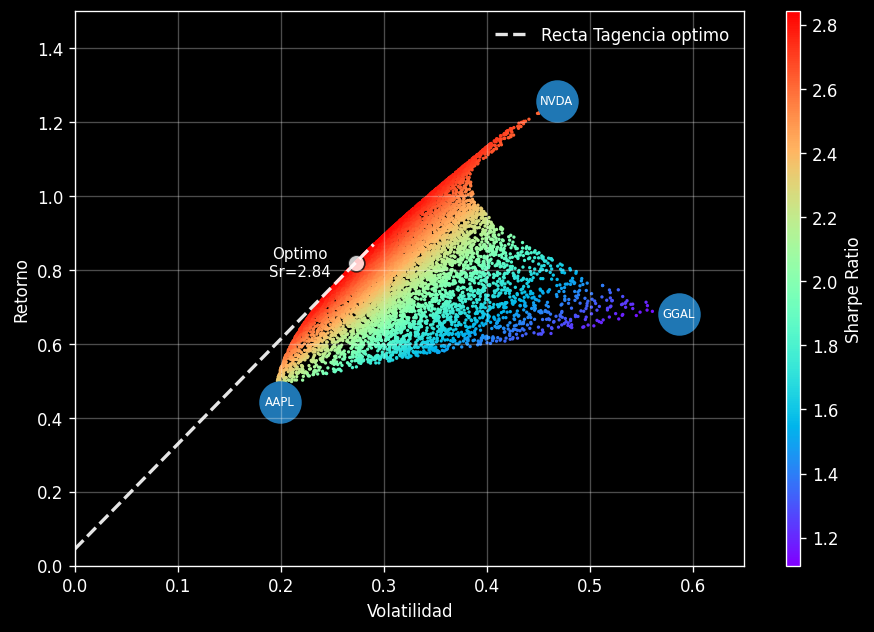

In [ ]:
import matplotlib.pyplot as plt

plt.style.use('dark_background')
plt.rcParams['figure.dpi'] = 120
fig, ax = plt.subplots(figsize=(9,6))
chart = ax.scatter(carteras.volatilidad, carteras.retorno, c=carteras['sharpe'], s=1, cmap='rainbow')

fig.colorbar(chart, label='Sharpe Ratio', aspect=40)
ax.set_xlabel('Volatilidad')
ax.set_ylabel('Retorno')

optimo_txt = f'Optimo\nSr={carteras["sharpe"].max():.2f}'
ax.scatter(optimo.volatilidad, optimo.retorno, c='white', alpha=0.8, edgecolors='black', s=100)
ax.text(optimo.volatilidad*0.8, optimo.retorno, optimo_txt, fontsize=9, c='white', ha='center', va='center')

for ticker in df.columns:
    vol = datosTickers.loc[ticker,'volatilidad']
    ret = datosTickers.loc[ticker,'retorno']
    ax.scatter(vol, ret,  c='tab:blue', s=600)
    ax.text(vol, ret, ticker, fontsize=7, c='w', ha='center', va='center')

m = (optimo.retorno - FREE_RISK) /  optimo.volatilidad
tg = [m * x + FREE_RISK for x in [i/100 for i in range(30)]]
ax.plot([i/100 for i in range(30)], tg, c='white', lw=2, ls='--', alpha=0.9, label='Recta Tagencia optimo')
ax.legend(frameon=False)
ax.set_xlim(0,0.65)
ax.set_ylim(0,1.5)
ax.grid(alpha=0.3)

# NCO

In [ ]:
import warnings

warnings.filterwarnings("ignore")
#pd.options.display.float_format = '{:.4%}'.format

start = '2021-01-01'
end = '2023-12-30'

assets = ['GGAL','BBAR','BMA','SUPV',
          'LOMA','CRESY','TEO',
          'MELI','BTC-USD','ETH-USD',
          'BABA','KO','VZ','SQQQ','SH','SDOW']
assets.sort()

data = yf.download(assets, start = start, end = end)
data = data.loc[:,('Close', slice(None))]
data.columns = assets
Y = data[assets].pct_change().dropna()

[*********************100%***********************]  16 of 16 completed


In [ ]:
pip install Riskfolio-Lib --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.0/315.0 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.3/243.3 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.4/169.4 kB 9.9 MB/s eta 0:00:00


Metricas de Riesgo:

https://riskfolio-lib.readthedocs.io/en/latest/risk.html

<Axes: >

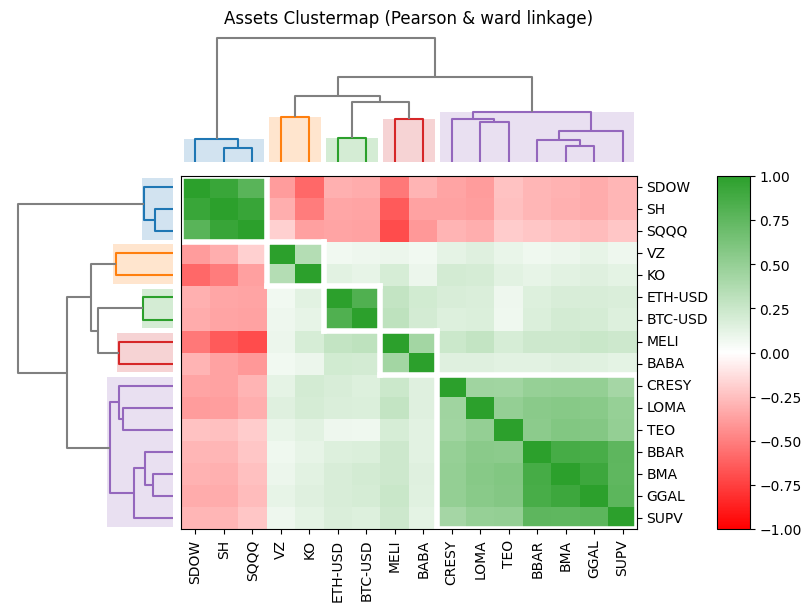

In [ ]:
import riskfolio as rp
import matplotlib as mpl
import matplotlib.pyplot as plt
cmap = mpl.colors.LinearSegmentedColormap.from_list("", ["red", "white", "tab:green"])

plt.style.use('default')
fig, ax = plt.subplots(figsize=(8,6))
rp.plot_clusters(returns=Y,
                      codependence='pearson',
                      linkage='ward',
                      cmap= cmap,
                      k=5,
                      leaf_order=True,
                      dendrogram=True,
                      linecolor='white',
                      ax=ax)

| `codependence` | Qué mide                          | Cuándo usar                                                 | Ventajas                                         | Limitaciones / Comentarios                            |
|----------------|------------------------------------|--------------------------------------------------------------|--------------------------------------------------|--------------------------------------------------------|
| `'pearson'`    | Correlación lineal                | Portfolios clásicos con retornos normales                    | Simple, rápido, bien conocido                    | No capta relaciones no lineales, sensible a outliers   |
| `'spearman'`   | Correlación de rangos (monótona)  | Series con relaciones no lineales suaves                     | Menos sensible a outliers, ordena por tendencia  | No capta relaciones complejas                          |
| `'kendall'`    | Concordancia de pares             | Pocos datos o necesidad de robustez estadística              | Más estable que Spearman                         | Ligeramente más costoso computacionalmente             |
| `'distance'`   | Distancia euclídea entre retornos | Diversificación por *forma* de retorno                       | No requiere supuestos estadísticos               | No capta dependencia estadística real                  |
| `'mutual_info'`| Dependencia total (lineal y no)   | Activos alternativos, relaciones no lineales complejas       | Captura cualquier tipo de dependencia            | Más costoso de computar, menos intuitivo               |


| `linkage`     | Qué hace                               | Cuándo usar                                                  | Ventajas                                          | Limitaciones / Comentarios                           |
|---------------|-----------------------------------------|---------------------------------------------------------------|---------------------------------------------------|-------------------------------------------------------|
| `'single'`    | Usa la menor distancia entre elementos  | Clustering conservador, evita agrupaciones agresivas         | Simplicidad, forma clusters delgados              | Sensible a outliers, forma cadenas (efecto "chaining")|
| `'complete'`  | Usa la mayor distancia entre elementos  | Cuando se desea clusters bien separados                       | Forma clusters compactos                          | Puede ignorar estructuras internas del grupo          |
| `'average'`   | Promedia todas las distancias cruzadas  | Balance entre single y complete                               | Más estable, buen desempeño general               | Puede suavizar estructuras reales                     |
| `'ward'`      | Minimiza la varianza intra-cluster      | Portfolios donde querés grupos internamente homogéneos        | Muy usado en finanzas, robusto y efectivo         | Requiere distancia euclídea, no funciona con todas las métricas |
| `'centroid'`  | Usa el centroide del cluster            | Visualización y segmentación con pocos activos               | Fácil interpretación                              | Puede generar resultados inconsistentes (no monotónico)|
| `'median'`    | Similar a centroid, pero más robusto    | Situaciones con ruido o valores extremos                      | Menos sensible a valores atípicos                 | Pocas ventajas claras sobre otros métodos             |
| `'DBHT'`      | Clustering basado en MST + jerarquía    | Cuando se quiere estructura jerárquica fiel al mercado        | Captura bien jerarquías de correlación            | Solo funciona con `distance` o `mutual_info`          |


In [ ]:
# help(rp.HCPortfolio)

## Medidas del riesgo para el parametro "rm"

| Clave       | Descripción                                                             |
|-------------|-------------------------------------------------------------------------|
| 'vol'       | Desviación estándar                                                     |
| 'MV'        | Varianza                                                                |
| 'KT'        | Raiz cuadrada de Curtosis                                               |
| 'MAD'       | Desviación media absoluta                                                |
| 'MSV'       | Semi Desviación estándar (de los retornos negativos)                      |
| 'SKT'       | Raiz cuadrada de la semicurtosis                                          |
| 'FLPM'      | Ratio Omega                          |
| 'SLPM'      | Ratio Sortino                        |
| 'VaR'       | Valor en riesgo                                                         |
| 'CVaR'      | Valor en riesgo condicional                                             |
| 'TG'        | Gini de cola                                                            |
| 'EVaR'      | Valor en riesgo entrópico                                                |
| 'RLVaR'     | Valor en riesgo relativista                                              |
| 'WR'        | Peor realización (Minimax)                                               |
| 'RG'        | Rango de rendimientos                                                    |
| 'CVRG'      | Rango de rendimientos de valor en riesgo condicional                     |
| 'TGRG'      | Rango de rendimientos de Gini de cola                                     |
| 'MDD'       | CALMAR    |
| 'ADD'       | Drawdown Medio en relación a los rendimientos   |
| 'DaR'       | Drawdown en relación al riesgo de los rendimientos |
| 'CDaR'      | Drawdown en relación al riesgo condicional de los rendimientos  |
| 'EDaR'      | Drawdown en relación al riesgo entrópico de los rendimientos  |
| 'RLDaR'     | Drawdown en relación al riesgo relativista de los rendimientos  |
| 'UCI'       | Índice de úlcera de los rendimientos               |
| 'MDD_Rel'   | DrawDown máxima en relación a los rendimientos acumulados      |
| 'ADD_Rel'   | DrawDown promedio en relación a los rendimientos acumulados    |
| 'DaR_Rel'   | DrawDown en relación al riesgo de los rendimientos acumulados  |
| 'CDaR_Rel'  | DrawDown en relación al riesgo condicional de los rendimientos acumulados |
| 'EDaR_Rel'  | DrawDown en relación al riesgo entrópico de los rendimientos acumulados |
| 'RLDaR_Rel' | DrawDown en relación al riesgo relativista de los rendimientos acumulados |
| 'UCI_Rel'   | Índice de úlcera de los rendimientos acumulados                |


In [ ]:
#help(port.optimization)

In [ ]:
# Creamos el portafolio por el metodo NCO
port = rp.HCPortfolio(returns=Y)

model='NCO' # podrian ser HRP, HERC or NCO
            # 'HRP': Hierarchical Risk Parity. (castiga clusteres de mayor riesgo)
            # 'HERC': Hierarchical Equal Risk Contribution. (pondera de modo que todos los activos contribuyan igual en riesgo)
            # 'HERC2': HERC pero pesos flat dentro de los clusters.


codependence = 'pearson'
method_cov = 'hist' # Opciones: ewma1, ewma2, ledoit, oas, shrunk, gl, jlogo, fixed, spectral, shrink, gerber1, gerber2, custom_cov
obj = "MinRisk" #  Otros: 'Utility', 'Sharpe' or 'ERC'
rm = 'MV' # Ver tabla
FREE_RISK = 0.045
l = 2 # Factor de aversion al riesgo (para cuando el objetivo es la utilidad)
linkage = 'ward' # Metodo usado para construir los clusteres (single, complete, average, etc)
max_k = 10 # Max numero de clusters

w = port.optimization(model=model,
                      codependence = codependence,
                      method_cov = method_cov,
                      obj = obj,
                      rm = rm,
                      rf = FREE_RISK,
                      l = l,
                      linkage = linkage,
                      max_k = max_k)
w

,weights
BABA,4.018950e-02
BBAR,8.977485e-11
BMA,4.459750e-10
BTC-USD,2.959025e-02
CRESY,5.947918e-03
ETH-USD,5.706853e-11
GGAL,3.371058e-03
KO,2.554346e-01
LOMA,2.882881e-02
MELI,3.004303e-02


#### Parametrizacion de method_cov

| `method_cov`  | Qué hace                                          | Cuándo usar                                                | Comentario clave                                           |
|---------------|---------------------------------------------------|-------------------------------------------------------------|------------------------------------------------------------|
| `'hist'`      | Covarianza empírica (clásica)                    | Series limpias y suficientes datos                         | Muy sensible al ruido y outliers                           |
| `'ewma1'`     | Exponential Weighted Moving Average (λ=0.94)     | Capturar dinámica de corto plazo                          | Reacciona rápido a cambios, pero puede sobreajustar        |
| `'ewma2'`     | EWMA con λ=0.97                                  | Menor sensibilidad a ruido que `ewma1`                     | Más suavizada, útil para portfolios más estables           |
| `'ledoit'`    | Shrinkage hacia la identidad (Ledoit-Wolf)       | Datos ruidosos o pocas observaciones                      | Reduce error de estimación, muy robusto                    |
| `'oas'`       | Oracle Approximating Shrinkage                   | Similar a Ledoit pero computacionalmente eficiente         | Buen desempeño general, sin tuning manual                 |
| `'shrunk'`    | Shrinkage personalizado                          | Cuando querés controlar manualmente el grado de shrinkage | Necesita definir `delta`                                   |
| `'gl'`        | Graphical Lasso (cov. dispersa, estimación sparse) | Alta dimensionalidad, muchas variables                   | Impone estructura esparsa, útil en carteras grandes        |
| `'jlogo'`     | Jackknife Ledoit-Wolf                            | Cuando querés shrinkage robusto con baja varianza          | Mejor performance en simulaciones                          |
| `'fixed'`     | Covarianza fija definida por el usuario          | Backtesting o pruebas con matriz exógena                   | Necesita pasarla como parámetro externo                    |
| `'spectral'`  | Filtro espectral (PCA shrinkage)                 | Eliminar ruido de alto orden                              | Útil cuando hay muchas series con ruido similar            |
| `'shrink'`    | Alias para `'ledoit'`                            | —                                                           | Mismo resultado que `'ledoit'`                             |
| `'gerber1'`   | Covarianza no lineal de Gerber (1)               | Relación no lineal entre activos                           | Más robusta que Pearson si hay dependencias complejas      |
| `'gerber2'`   | Variante ajustada de Gerber (2)                  | Idem anterior, pero ajustada para menos sesgo              | Aún más robusta, útil en cripto o activos alternativos     |
| `'custom_cov'`| Usa una matriz de covarianza provista por el usuario | Total libertad (machine learning, simulaciones, etc.) | Debés definir la matriz `cov_matrix` vos mismo             |


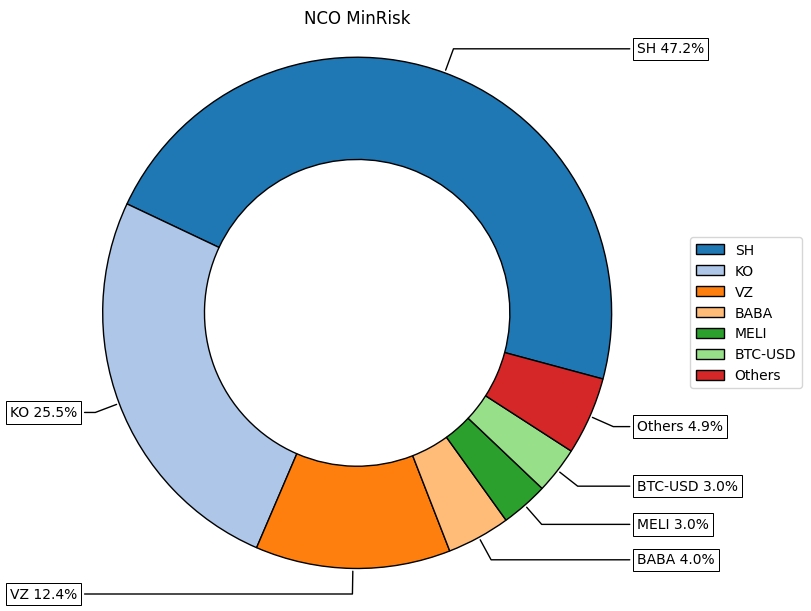

In [ ]:
ax = rp.plot_pie(w=w,
                 title='NCO MinRisk',
                 others=0.05,
                 nrow=25,
                 cmap="tab20",
                 height=6,
                 width=8,
                 ax=None)

## NCO: Contribucion al riesgo por activo

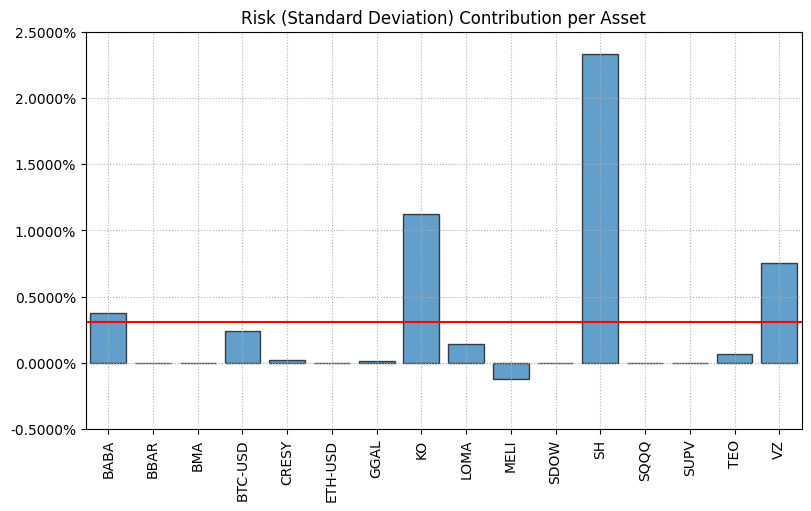

In [ ]:
mu = Y.mean()
cov = Y.cov() # Covariance matrix
returns = Y # Returns of the assets

ax = rp.plot_risk_con(w=w,
                      cov=cov,
                      returns=returns,
                      rm=rm,
                      rf=0,
                      alpha=0.05,
                      color="tab:blue",
                      height=5,
                      width=8,
                      t_factor=252,
                      ax=None)

## NCO con restricciones

In [ ]:
asset_classes = {'Assets': ['GGAL','BBAR','BMA','SUPV', 'LOMA','CRESY','TEO',
                            'MELI','BTC-USD','ETH-USD', 'BABA','KO','VZ','SQQQ','SH','SDOW'],
                 'Industry': ['ADR Banco','ADR Banco',
                              'ADR Banco', 'ADR Banco',
                              'ADR Otros','ADR Otros','ADR Otros',
                              'Marketplaces','Cryptos','Cryptos',
                              'Marketplaces','USA Conservador','USA Conservador','Shorts',
                              'Shorts','Shorts']}

asset_classes = pd.DataFrame(asset_classes)
asset_classes = asset_classes.sort_values(by=['Assets'])

constraints = {'Disabled': [False,        False,      False, False, False],
               'Type':     ['Assets',    'Assets',    'All Assets', 'Each asset in a class', 'Each asset in a class'],
               'Set':      ['',          '',          '','Industry', 'Industry'],
               'Position': ['TEO',      'SQQQ',       '', 'Cryptos', 'ADR Bancos'],
               'Sign':     ['>=',       '<=',         '<=', '>=', '<='],
               'Weight':   [0.05,       0.03,          0.15, 0.02, 0.06]}

constraints = pd.DataFrame(constraints)

display(constraints)

,Disabled,Type,Set,Position,Sign,Weight
0,False,Assets,,TEO,>=,0.05
1,False,Assets,,SQQQ,<=,0.03
2,False,All Assets,,,<=,0.15
3,False,Each asset in a class,Industry,Cryptos,>=,0.02
4,False,Each asset in a class,Industry,ADR Bancos,<=,0.06


In [ ]:
w_max, w_min = rp.hrp_constraints(constraints, asset_classes)

port.w_max = w_max
port.w_min = w_min

w_1 = port.optimization(model=model,
                        codependence = codependence ,
                        method_cov = method_cov ,
                        obj=obj,
                        rm=rm,
                        rf=FREE_RISK,
                        l=l,
                        linkage=linkage,
                        max_k=max_k)

display(w_1.T)

,BABA,BBAR,BMA,BTC-USD,CRESY,ETH-USD,GGAL,KO,LOMA,MELI,SDOW,SH,SQQQ,SUPV,TEO,VZ
weights,0.139819,3.123270e-10,1.551548e-09,0.102945,0.020693,0.02,0.011728,0.15,0.100296,0.10452,4.345348e-10,0.15,2.270996e-11,1.265864e-09,0.05,0.15


<Axes: title={'center': 'NCO MinRisk c/restricciones'}>

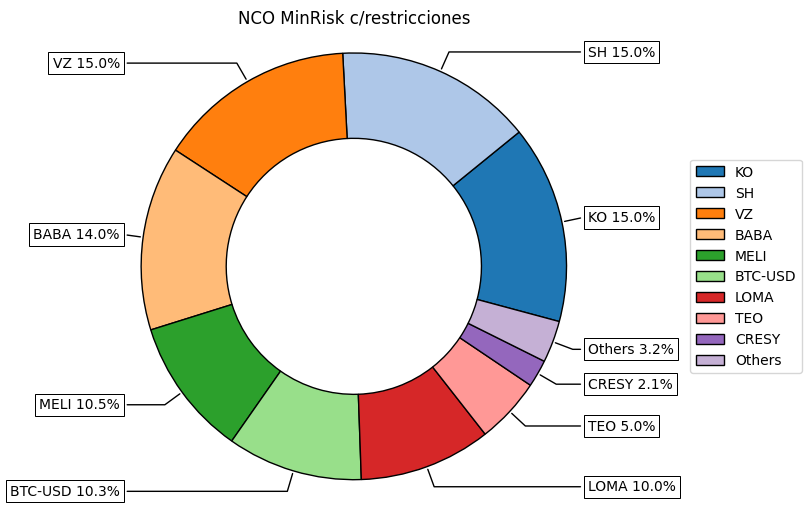

In [ ]:
plt.style.use('default')
fig, ax = plt.subplots(figsize=(8,5))
rp.plot_pie(w=w_1, title='NCO MinRisk c/restricciones', others=0.05, nrow=25, cmap="tab20", height=8, width=10, ax=ax)

## NCO con restricciones. Contribucion al riesgo por activo

<Axes: title={'center': 'Risk (Standard Deviation) Contribution per Asset'}>

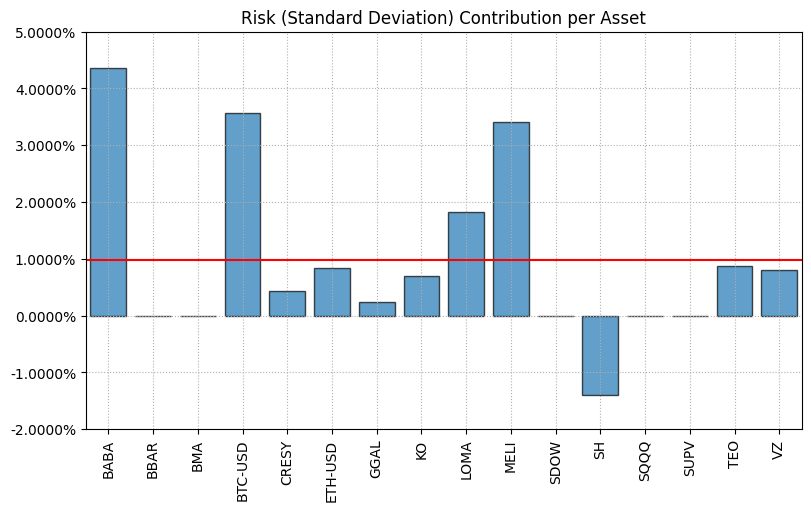

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
rp.plot_risk_con(w=w_1, cov=Y.cov(), returns=Y, rm=rm, rf=FREE_RISK, alpha=0.05, color="tab:blue", height=6, width=10, t_factor=252, ax=ax)

# Black Litterman

https://pypi.org/project/pyportfolioopt/

https://github.com/robertmartin8/PyPortfolioOpt

In [ ]:
!pip install PyPortfolioOpt -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.1/220.1 kB 9.9 MB/s eta 0:00:00


In [ ]:
prices = data
market_prices = yf.download("SPY", start="2021-01-01")["Close"]

[*********************100%***********************]  1 of 1 completed


In [ ]:
mcaps = {}
for t in assets:
    stock = yf.Ticker(t)
    mcaps[t] = stock.info.get("marketCap", 10**10)
mcaps

{'BABA': 289633697792,
 'BBAR': 4421730816,
 'BMA': 5924975104,
 'BTC-USD': 2137769639936,
 'CRESY': 722572928,
 'ETH-USD': 304600252416,
 'GGAL': 10078407680,
 'KO': 308917436416,
 'LOMA': 1608084608,
 'MELI': 127140462592,
 'SDOW': 10000000000,
 'SH': 10000000000,
 'SQQQ': 10000000000,
 'SUPV': 1417135360,
 'TEO': 3112337664,
 'VZ': 182647947264}

In [ ]:
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting

S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
delta = black_litterman.market_implied_risk_aversion(market_prices)
delta

np.float64(4.191444945396617)

In [ ]:
# Este es el PI
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
market_prior

,0
BABA,0.202311
BBAR,0.129137
BMA,0.132847
BTC-USD,0.890189
CRESY,0.126032
ETH-USD,1.004324
GGAL,0.136045
KO,0.036902
LOMA,0.096812
MELI,0.253595


In [ ]:
# views es Q
viewdict = {
    'BMA': 0.25, # vision alcista BMA +25%
    'LOMA': 0.4, # muy alcista para LOMA + 40%
    'CRESY': 0.0, # view neutra
    'TEO': 0.05,  # view levementa alcista para Telecom
    'MELI': -0.1, # Bajista para Meli
    'BTC-USD': 0.25, # Alcista para BTC, poco menos para ETH
    'ETH-USD': 0.2,
    'BABA': 0.15, # Alcista para Alibaba +15%
    'KO': 0.0,
    'VZ': 0.0,
    'SQQQ': 0.08, # vision bajista para el nasdaq
    'SH': -0.03,  # vision alcista leve para sp500
    'SDOW': -0.07 # vision alcista para el dow
}

# Este seria como el inverso de OMEGA
confidences = [
    0.3, # BMA
    0.5, # LOMA
    0.5, # CRESY
    0.5, # TEO
    0.8, # MELI
    0.2, # BTC.  En BTC y ETH son en los que estoy mas inseguro de mi view
    0.2, # ETH
    0.8, # BABA
    0.9, # KO.  En coca cola y verizon son en los que mas confianza tengo de mi view
    0.9, # VZ
    0.8, # SQQQ
    0.8, # SH
    0.8, # SDOW
]

"""
Les dejo ejemplos de views relativas, la lib permite o relativas o absolutas,
asi que para meter ambas habria que transformar las absolutas en relativas
contra un activo de referencia al que le damos view neutral por ejemplo
Si quisieramos pasar las views relativas debemos poner el karg absolute_views=False
y pasar P=P y Q=Q como views y mapeo, y por supuesto las view_confidences de la misma dimension
"""
# view relativa 1: GGAL > SUPV + 11%
# view relativa 1: GGAL > BBAR + 7%
P = np.zeros((2, len(assets)))
P[0, assets.index('GGAL')] = 1
P[0, assets.index('SUPV')] = -1
P[1, assets.index('GGAL')] = 1
P[1, assets.index('BBAR')] = -1

# Matriz Q para las vistas relativas
Q = np.array([0.11, 0.07])



bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict,
                         omega="idzorek", view_confidences=confidences)

## Calculo de omega

<Axes: title={'center': 'Omega'}>

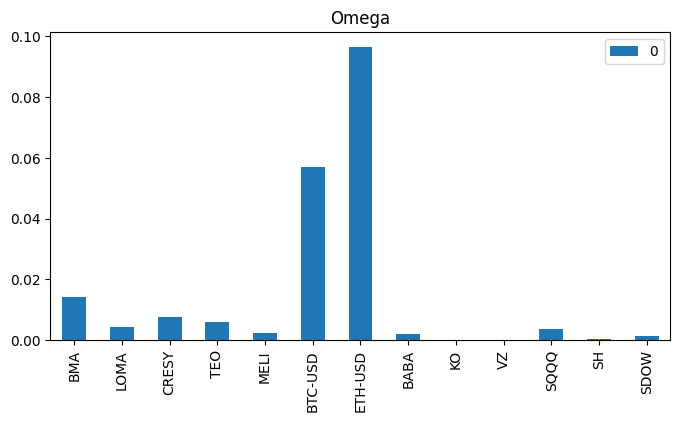

In [ ]:
omega = bl.omega
pd.DataFrame(np.diag(omega), index=viewdict.keys()).plot(kind='bar', figsize=(8,4), title='Omega')

## Estimacion de retornos a posteriori

In [ ]:
bl = BlackLittermanModel(S, pi="market", market_caps=mcaps, risk_aversion=delta,
                        absolute_views=viewdict, omega=bl.omega)

ret_bl = bl.bl_returns() # Estimacion de los retornos a posteriori

rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)],
             index=["Prior", "Posterior", "Views"]).T
rets_df

,Prior,Posterior,Views
BABA,0.202311,0.128563,0.15
BBAR,0.129137,0.174087,NaN
BMA,0.132847,0.171796,0.25
BTC-USD,0.890189,0.638949,0.25
CRESY,0.126032,0.062598,0.00
ETH-USD,1.004324,0.692148,0.20
GGAL,0.136045,0.160274,NaN
KO,0.036902,0.001881,0.00
LOMA,0.096812,0.195350,0.40
MELI,0.253595,-0.036814,-0.10


<Axes: >

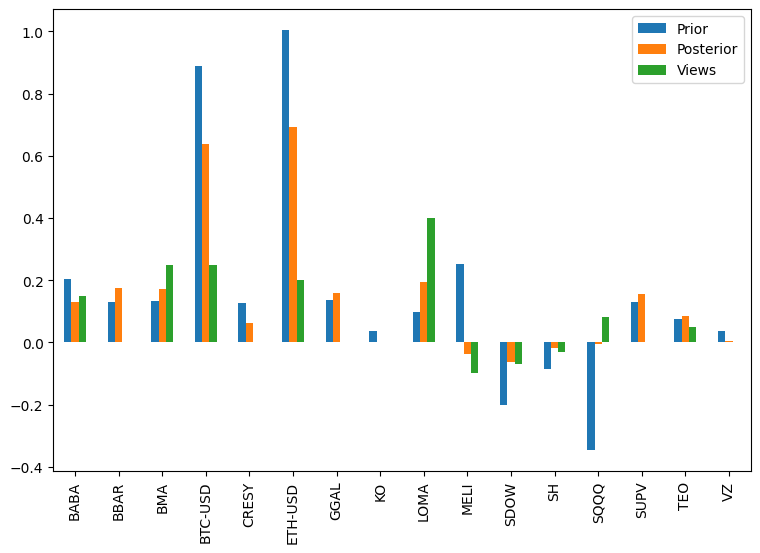

In [ ]:
rets_df.plot.bar(figsize=(9,6))

## Optimizacion por sharpe basado en retornos a posteriori de BL

Justamente hice todo esto para tener un vertor de retornos a posteriori que no se base solo en el pasado, sino que tenga en cuenta dos cosas:
1. La condicion de euilibrio previa del mercado (mkt caps y matriz de covarianzas a priori)
2. La view del inveror y su incertidumbre al respecto

Incorporo entonces este vector de retornos a los modelos tradicionales como Markowitz (Les dejo de tarea incorporarlo a un NCO con restricciones)

In [ ]:
from pypfopt import EfficientFrontier, objective_functions

S_bl = bl.bl_cov()
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()

In [ ]:
pd.DataFrame([weights]).T

,0
BABA,0.05275
BBAR,0.06273
BMA,0.06471
BTC-USD,0.27291
CRESY,0.00317
ETH-USD,0.25490
GGAL,0.05597
KO,0.00000
LOMA,0.09752
MELI,0.00000


<Axes: title={'center': 'BL'}>

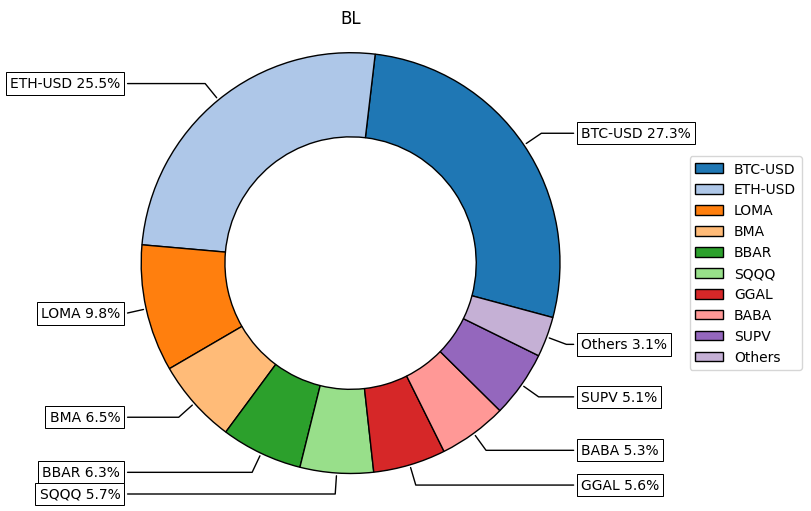

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
rp.plot_pie(w=pd.DataFrame([weights]).T, title='BL', others=0.05, nrow=25, cmap="tab20", height=8, width=10, ax=ax)